<a href="https://colab.research.google.com/github/hamdansyaif/DeepLearning/blob/main/Week_5/Tugas_5_PyTorch%26Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Tugas 5
1. Buat model Deep learning (PyTorch and Tensorflow).
2. Gunakan Matriks Evaluasi (Akurasi,Presisi,Recall,F1Squared, AUC, ROC). Visualisasikan matriks akurasi dan loss.
3. Beri penjelasan untuk setiap persamaan matematika yang ada.
4. Akurasi pada Training dan Testing Set Minimal Sebesar 70%.
5. Disarankan untuk mengerjakan tugas menggunakan Google Colab. Coba gunakan Google Colab dengan
     T4 GPU atau TPU agar proses pelatihan model menjadi lebih cepat.

### Import Dataset dan Setup Awal

In [101]:
# Cek dan aktifkan GPU jika tersedia
import tensorflow as tf

# Cek TensorFlow
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))



TensorFlow version: 2.18.0
GPU Available:  []


In [102]:

# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import nltk
from nltk.corpus import stopwords
import re
import string
import time
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')

# Download resource untuk NLP
!pip install nltk
nltk.download('punkt')
nltk.download('stopwords')

# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Preprocessing Dataset

In [103]:
# Load dataset
import pandas as pd
import re
import string

# Path dataset
data_path = '/content/sample_data/ReviewTokoBaju.csv'
print("📥 Memuat dataset dari:", data_path)
data = pd.read_csv(data_path)

# Tampilkan info awal
print("Jumlah data sebelum preprocessing:", len(data))
print("Kolom yang tersedia:", data.columns.tolist())

# Fungsi preprocessing teks
def bersihkan_teks(teks):
    if pd.isnull(teks):
        return ""

    teks = teks.lower()
    teks = teks.translate(str.maketrans('', '', string.punctuation))  # hilangkan tanda baca
    teks = re.sub(r'\d+', '', teks)  # hilangkan angka
    teks = re.sub(r'\s+', ' ', teks).strip()  # hilangkan spasi berlebih
    return teks

# Terapkan preprocessing ke kolom review
print("\n🔧 Melakukan preprocessing pada teks ulasan...")
data['Cleaned Review'] = data['Review Text'].apply(bersihkan_teks)

# Preview hasil preprocessing
print("\n🧾 Contoh hasil sebelum dan sesudah dibersihkan:")
for idx in range(3):
    original = data['Review Text'].iloc[idx][:100]
    cleaned = data['Cleaned Review'].iloc[idx][:100]
    print(f"\nsebelum  : {original}...")
    print(f"Sesudah   : {cleaned}...")

📥 Memuat dataset dari: /content/sample_data/ReviewTokoBaju.csv
Jumlah data sebelum preprocessing: 23486
Kolom yang tersedia: ['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name']

🔧 Melakukan preprocessing pada teks ulasan...

🧾 Contoh hasil sebelum dan sesudah dibersihkan:

sebelum  : Absolutely wonderful - silky and sexy and comfortable...
Sesudah   : absolutely wonderful silky and sexy and comfortable...

sebelum  : Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never...
Sesudah   : love this dress its sooo pretty i happened to find it in a store and im glad i did bc i never would ...

sebelum  : I had such high hopes for this dress and really wanted it to work for me. i initially ordered the pe...
Sesudah   : i had such high hopes for this dress and really wanted it to work for me i initially ordered the pet...


In [104]:
from sklearn.model_selection import train_test_split

# Pilih fitur dan label
fitur = data['Cleaned Review']
label = data['Recommended IND']

# Bagi data menjadi training dan testing set
X_latih, X_uji, y_latih, y_uji = train_test_split(
    fitur, label, test_size=0.2, random_state=42, stratify=label
)

# Tampilkan informasi distribusi
print(f"\n📊 Jumlah data latih: {len(X_latih)}")
print(f"📊 Jumlah data uji: {len(X_uji)}")
print(f"🔍 Distribusi label (Training): {y_latih.value_counts().to_dict()}")
print(f"🔍 Distribusi label (Testing): {y_uji.value_counts().to_dict()}")



📊 Jumlah data latih: 18788
📊 Jumlah data uji: 4698
🔍 Distribusi label (Training): {1: 15451, 0: 3337}
🔍 Distribusi label (Testing): {1: 3863, 0: 835}


In [105]:
from collections import Counter

def buat_kamus_kata(daftar_teks, batas_vocab=10000):
    # Gabungkan semua kalimat dan pecah menjadi kata
    semua_kata = ' '.join(daftar_teks).split()

    # Hitung frekuensi setiap kata
    frekuensi_kata = Counter(semua_kata)

    # Ambil kata yang paling sering muncul (dikurangi token khusus)
    kata_teratas = frekuensi_kata.most_common(batas_vocab - 2)

    # Inisialisasi kamus dengan token spesial
    kamus = {'<PAD>': 0, '<UNK>': 1}
    for kata, _ in kata_teratas:
        kamus[kata] = len(kamus)

    return kamus

print("🔠 Sedang membuat kamus kata dari data latih...")
kamus_kata = buat_kamus_kata(X_latih, batas_vocab=10000)
ukuran_kamus = len(kamus_kata)
print(f"📚 Total kata dalam kamus: {ukuran_kamus}")

# Tampilkan sebagian isi kamus
print("\n📌 Contoh 20 entri pertama dalam kamus:")
for i, (kata, indeks) in enumerate(kamus_kata.items()):
    if i >= 10:
        break
    print(f"{kata}: {indeks}")


🔠 Sedang membuat kamus kata dari data latih...
📚 Total kata dalam kamus: 10000

📌 Contoh 20 entri pertama dalam kamus:
<PAD>: 0
<UNK>: 1
the: 2
i: 3
and: 4
a: 5
it: 6
is: 7
this: 8
to: 9


In [106]:
import numpy as np

# Fungsi konversi teks ke sequence angka
def ubah_teks_ke_sequence(teks, kamus, panjang_maks=100):
    # Pecah teks menjadi daftar kata
    tokens = teks.split()

    # Ubah tiap kata menjadi indeks dari kamus, jika tidak ditemukan pakai <UNK>
    hasil_sequence = [kamus.get(kata, kamus['<UNK>']) for kata in tokens[:panjang_maks]]

    # Tambahkan padding jika panjang belum cukup
    if len(hasil_sequence) < panjang_maks:
        hasil_sequence += [kamus['<PAD>']] * (panjang_maks - len(hasil_sequence))

    return hasil_sequence

# Tentukan panjang sequence maksimal
panjang_sequence = 100

# Proses seluruh data teks menjadi sequence angka
print(f"🔁 Mengubah teks menjadi urutan angka dengan panjang {panjang_sequence}...")
X_latih_seq = np.array([ubah_teks_ke_sequence(teks, kamus_kata, panjang_sequence) for teks in X_latih])
X_uji_seq = np.array([ubah_teks_ke_sequence(teks, kamus_kata, panjang_sequence) for teks in X_uji])

# Info bentuk hasil
print(f"✅ X_latih_seq shape: {X_latih_seq.shape}")
print(f"✅ X_uji_seq shape: {X_uji_seq.shape}")

# Simpan hasil preprocessing ke file
print("\n💾 Menyimpan data hasil preprocessing...")
np.save('X_latih_seq.npy', X_latih_seq)
np.save('X_uji_seq.npy', X_uji_seq)
np.save('y_latih.npy', y_latih.values)
np.save('y_uji.npy', y_uji.values)

# Contoh hasil konversi
print("\n🧾 Contoh hasil sequence dari salah satu review:")
print(f"Teks asli: {X_latih.iloc[0][:50]}...")
print(f"Sequence: {X_latih_seq[0][:20]}...")


🔁 Mengubah teks menjadi urutan angka dengan panjang 100...
✅ X_latih_seq shape: (18788, 100)
✅ X_uji_seq shape: (4698, 100)

💾 Menyimpan data hasil preprocessing...

🧾 Contoh hasil sequence dari salah satu review:
Teks asli: i had my eye on this tee for awhile and finally or...
Sequence: [   3   67   18  651   12    8  302   13 1620    4  618   53    2 7765
   10    2   48   33  666   33]...


### Tensorflow/Keras


### Proses Training RNN Models

In [107]:
import numpy as np

# Memuat data yang sudah diproses
X_latih_seq = np.load('X_latih_seq.npy')
X_uji_seq = np.load('X_uji_seq.npy')
y_latih = np.load('y_latih.npy')
y_uji = np.load('y_uji.npy')

print(f"Shape X_latih_seq: {X_latih_seq.shape}")
print(f"Shape X_uji_seq: {X_uji_seq.shape}")
print(f"Shape y_latih: {y_latih.shape}")
print(f"Shape y_uji: {y_uji.shape}")


Shape X_latih_seq: (18788, 100)
Shape X_uji_seq: (4698, 100)
Shape y_latih: (18788,)
Shape y_uji: (4698,)


In [108]:
import tensorflow as tf

# Tentukan parameter untuk model
input_length = 100  # Panjang sequence yang telah di-preprocess
vocab_size = ukuran_kamus  # Ukuran kamus
embedding_dim = 128  # Dimensi embedding untuk representasi kata
rnn_units = 64  # Jumlah unit dalam layer RNN
output_units = 1  # Karena ini klasifikasi biner (0 atau 1)
dropout_rate = 0.2  # Tingkat dropout untuk mencegah overfitting

# Membangun model RNN
model_rnn = tf.keras.Sequential([
    # Layer Embedding
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),

    # Layer RNN
    tf.keras.layers.SimpleRNN(rnn_units, dropout=dropout_rate, return_sequences=False),

    # Layer Dense output (aktivasi sigmoid untuk klasifikasi biner)
    tf.keras.layers.Dense(output_units, activation='sigmoid')
])

# Ringkasan model
model_rnn.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [109]:
from tensorflow.keras.metrics import AUC

model_rnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

print("✅ Model berhasil dikompilasi dengan metrik AUC!")


✅ Model berhasil dikompilasi dengan metrik AUC!


In [110]:
# Latih model
history = model_rnn.fit(
    X_latih_seq, y_latih,  # Data latih
    epochs=30,  # Jumlah epoch
    batch_size=64,  # Ukuran batch
    validation_data=(X_uji_seq, y_uji)  # Data validasi
)

print("✅ Model selesai dilatih!")


Epoch 1/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 43s 123ms/step - accuracy: 0.8155 - auc: 0.4968 - loss: 0.4735 - val_accuracy: 0.8223 - val_auc: 0.4963 - val_loss: 0.4681
Epoch 2/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.8253 - auc: 0.5561 - loss: 0.4594 - val_accuracy: 0.8218 - val_auc: 0.4981 - val_loss: 0.4707
Epoch 3/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.8319 - auc: 0.6207 - loss: 0.4370 - val_accuracy: 0.8120 - val_auc: 0.5019 - val_loss: 0.4884
Epoch 4/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.8480 - auc: 0.6754 - loss: 0.4075 - val_accuracy: 0.8093 - val_auc: 0.5123 - val_loss: 0.5238
Epoch 5/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.8423 - auc: 0.6519 - loss: 0.4186 - val_accuracy: 0.8099 - val_auc: 0.5120 - val_loss: 0.4988
Epoch 6/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.8598 - auc: 0.7173 - loss: 0.3778 - val_accuracy: 0.8095 - val_auc: 0.4960 - val_loss: 0.5105
Epoch 7/30
294/294 ━━━━━━━━

In [111]:
# Menyimpan model
model_rnn.save('model_rnn.h5')
print("💾 Model berhasil disimpan!")


💾 Model berhasil disimpan!


In [112]:
# Prediksi pada data uji
y_pred = model_rnn.predict(X_uji_seq)

# Ubah prediksi menjadi label biner (0 atau 1) dengan threshold 0.5
y_pred_bin = (y_pred > 0.5).astype(int)

# Evaluasi metrik
accuracy = accuracy_score(y_uji, y_pred_bin)
precision = precision_score(y_uji, y_pred_bin)
recall = recall_score(y_uji, y_pred_bin)
f1 = f1_score(y_uji, y_pred_bin)
roc_auc = roc_auc_score(y_uji, y_pred)

# Tampilkan hasil evaluasi
print(f"📊 Akurasi: {accuracy:.4f}")
print(f"📊 Presisi: {precision:.4f}")
print(f"📊 Recall: {recall:.4f}")
print(f"📊 F1 Score: {f1:.4f}")
print(f"📊 AUC: {roc_auc:.4f}")


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
📊 Akurasi: 0.8031
📊 Presisi: 0.8229
📊 Recall: 0.9692
📊 F1 Score: 0.8901
📊 AUC: 0.5040


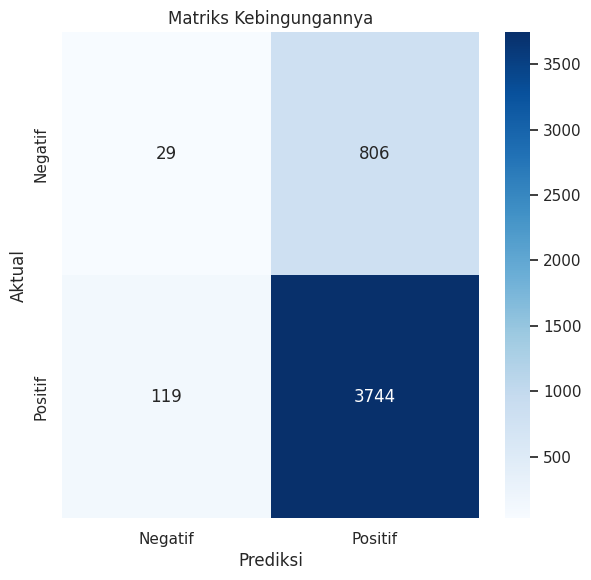

In [113]:
# Matriks kebingungannya
conf_matrix = confusion_matrix(y_uji, y_pred_bin)

# Visualisasi matriks kebingungan
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negatif", "Positif"], yticklabels=["Negatif", "Positif"])
plt.title("Matriks Kebingungannya")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()


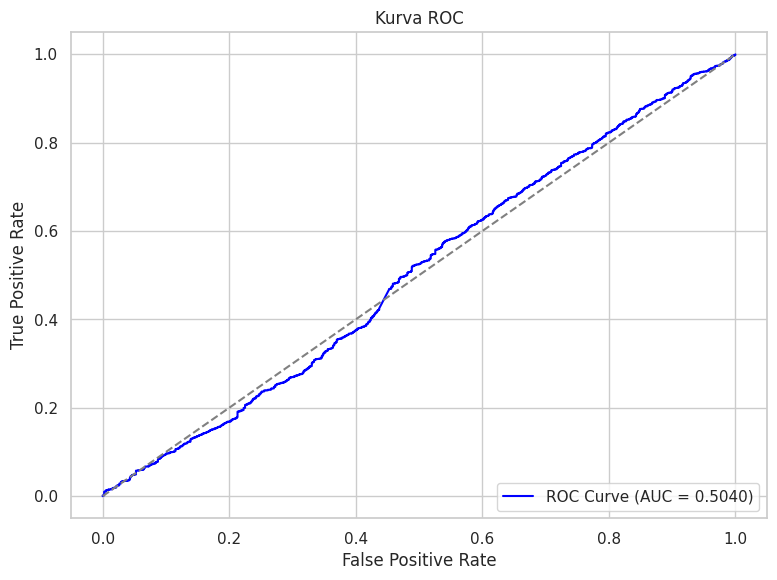

In [114]:
# Menghitung fpr, tpr, dan thresholds untuk ROC
fpr, tpr, thresholds = roc_curve(y_uji, y_pred)

# Visualisasi kurva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Kurva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


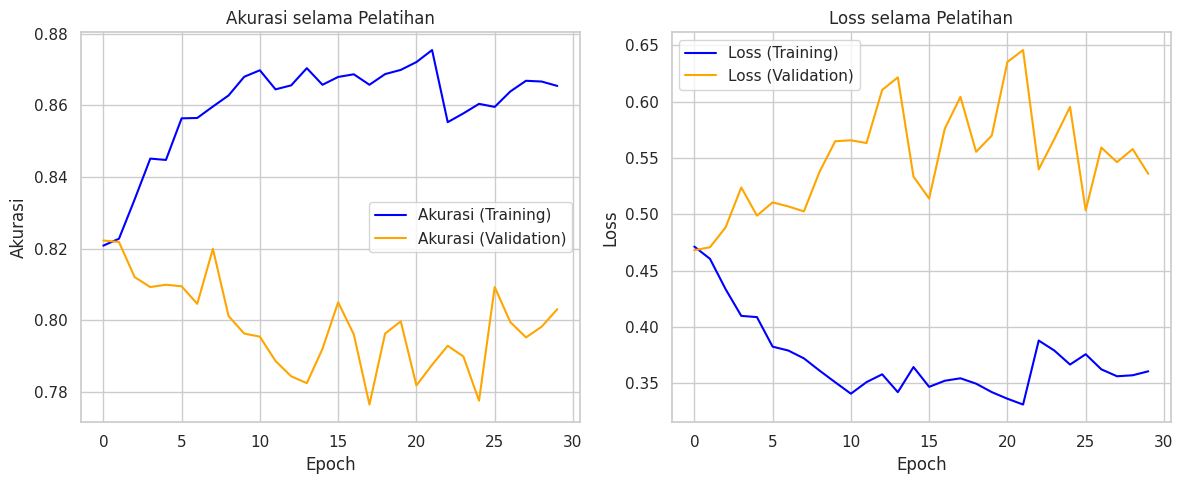

In [115]:
# Plot akurasi dan loss
plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi (Training)', color='blue')
plt.plot(history.history['val_accuracy'], label='Akurasi (Validation)', color='orange')
plt.title('Akurasi selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss (Training)', color='blue')
plt.plot(history.history['val_loss'], label='Loss (Validation)', color='orange')
plt.title('Loss selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Dalam pelatihan dan pengujian model **Recurrent Neural Networks (RNN)**, ada beberapa persamaan matematika yang berperan penting dalam proses **forward pass**, **backpropagation**, dan evaluasi model.

### 1. **Persamaan RNN untuk Forward Pass**

Recurrent Neural Networks (RNN) digunakan untuk memproses urutan data dengan cara "mengulang" informasi dari waktu sebelumnya ke waktu berikutnya. Berikut adalah persamaan dasar yang digunakan dalam forward pass RNN:

#### a. **Pemberian Input pada Waktu t**

Pada waktu $ t $, RNN menerima input $ x_t $ yang akan diproses untuk menghasilkan output $ y_t $ dan state tersembunyi $ h_t $. Persamaannya adalah sebagai berikut:

$$
h_t = f(W_h \cdot h_{t-1} + W_x \cdot x_t + b_h)
$$

- $ h_t $: Hidden state (state tersembunyi) pada waktu $ t $.
- $ h_{t-1} $: Hidden state pada waktu $ t-1 $, yang membawa informasi dari waktu sebelumnya.
- $ x_t $: Input pada waktu $ t $, misalnya, kata dalam kalimat atau data pada timestamp tertentu.
- $ W_h $: Matriks bobot yang menghubungkan hidden state pada waktu $ t-1 $ ke $ t $.
- $ W_x $: Matriks bobot yang menghubungkan input $ x_t $ ke hidden state $ h_t $.
- $ b_h $: Bias untuk hidden state.

Fungsi $ f(\cdot) $ biasanya adalah fungsi aktivasi seperti **tanh** atau **ReLU**, dan digunakan untuk memperkenalkan non-linearitas.

#### b. **Output pada Waktu t**

Setelah mendapatkan hidden state, model menghasilkan output $ y_t $ menggunakan persamaan berikut:

$$
y_t = g(W_y \cdot h_t + b_y)
$$

- $ y_t $: Output pada waktu $ t $ (misalnya, prediksi model).
- $ W_y $: Matriks bobot yang menghubungkan hidden state $ h_t $ ke output $ y_t $.
- $ b_y $: Bias untuk output.
- $ g(\cdot) $: Fungsi aktivasi pada output (misalnya, **softmax** untuk klasifikasi).

### 2. **Persamaan dalam Backpropagation Through Time (BPTT)**

Untuk melatih RNN, kita harus menghitung gradien terhadap parameter-parameter model menggunakan **Backpropagation Through Time (BPTT)**. BPTT adalah algoritma untuk menghitung gradien untuk RNN dengan "mengulangi" kembali informasi dari waktu $ t $ hingga waktu $ t-1 $.

#### a. **Gradien terhadap Hidden State**

Untuk menghitung gradien dari loss $ L $ terhadap hidden state $ h_t $, kita menggunakan aturan rantai:

$$
\frac{\partial L}{\partial h_t} = \frac{\partial L}{\partial y_t} \cdot \frac{\partial y_t}{\partial h_t} + \sum_{t+1}^{T} \frac{\partial L}{\partial h_{t+1}} \cdot \frac{\partial h_{t+1}}{\partial h_t}
$$

- $ \frac{\partial L}{\partial y_t} $ adalah gradien dari loss terhadap output $ y_t $.
- $ \frac{\partial y_t}{\partial h_t} $ adalah gradien dari output terhadap hidden state $ h_t $.
- $ \sum_{t+1}^{T} \frac{\partial L}{\partial h_{t+1}} \cdot \frac{\partial h_{t+1}}{\partial h_t} $ adalah kontribusi dari hidden states yang lebih jauh ke belakang (ini adalah bagian dari "backpropagation" yang berulang).

#### b. **Gradien terhadap Matriks Bobot**

Gradien terhadap matriks bobot (seperti $ W_x $, $ W_h $, dan $ W_y $) dihitung dengan menggunakan aturan rantai. Berikut adalah contoh gradien terhadap matriks bobot $ W_x $:

$$
\frac{\partial L}{\partial W_x} = \sum_{t=1}^{T} \frac{\partial L}{\partial h_t} \cdot \frac{\partial h_t}{\partial W_x}
$$

- $ \frac{\partial L}{\partial h_t} $ adalah gradien dari loss terhadap hidden state pada waktu $ t $.
- $ \frac{\partial h_t}{\partial W_x} $ adalah gradien dari hidden state terhadap bobot $ W_x $.

### 3. **Evaluasi Model dengan Matriks Evaluasi**

#### a. **Akurasi**

Akurasi adalah metrik evaluasi dasar yang mengukur persentase prediksi yang benar dibandingkan dengan total data:

$$
\text{Akurasi} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Sampel}}
$$

#### b. **Presisi**

Presisi mengukur seberapa banyak prediksi positif yang benar dibandingkan dengan semua prediksi positif yang dilakukan oleh model. Definisi matematikanya:

$$
\text{Presisi} = \frac{TP}{TP + FP}
$$

- $ TP $ = True Positives (jumlah prediksi positif yang benar).
- $ FP $ = False Positives (jumlah prediksi positif yang salah).

#### c. **Recall**

Recall (atau Sensitivitas) mengukur seberapa banyak label positif yang benar dapat ditemukan oleh model. Definisi matematikanya:

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

- $ FN $ = False Negatives (jumlah prediksi negatif yang salah).

#### d. **F1 Score**

F1 Score adalah rata-rata harmonik dari presisi dan recall, yang digunakan untuk mengukur keseimbangan antara keduanya:

$$
F1 = 2 \cdot \frac{\text{Presisi} \cdot \text{Recall}}{\text{Presisi} + \text{Recall}}
$$

#### e. **AUC (Area Under Curve)**

AUC mengukur area di bawah kurva ROC (Receiver Operating Characteristic). ROC menggambarkan trade-off antara **True Positive Rate** (TPR) dan **False Positive Rate** (FPR):

$$
\text{AUC} = \int_{0}^{1} \text{TPR}(FPR) \, dFPR
$$

AUC memberikan gambaran seberapa baik model membedakan antara kelas positif dan negatif. AUC mendekati 1 berarti model sangat baik, sedangkan AUC mendekati 0.5 menunjukkan model yang tidak lebih baik dari tebakan acak.

#### f. **ROC Curve**

Kurva ROC menggambarkan hubungan antara **True Positive Rate** (TPR) dan **False Positive Rate** (FPR) pada berbagai threshold.

$$
\text{TPR} = \frac{TP}{TP + FN}
$$
$$
\text{FPR} = \frac{FP}{FP + TN}
$$

- $ TN $ = True Negatives (jumlah prediksi negatif yang benar).

Kurva ROC digunakan untuk memvisualisasikan kinerja model klasifikasi biner.

### Proses Training LSTM Models

In [116]:
import numpy as np

# Load data hasil preprocessing
X_latih = np.load('X_latih_seq.npy')
X_uji = np.load('X_uji_seq.npy')
y_latih = np.load('y_latih.npy')
y_uji = np.load('y_uji.npy')

print(f"✅ Data loaded: X_latih {X_latih.shape}, X_uji {X_uji.shape}")


✅ Data loaded: X_latih (18788, 100), X_uji (4698, 100)


In [117]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Parameter dasar
vocab_size = len(kamus_kata)  # kamus_kata dari sebelumnya
embedding_dim = 64
max_length = 100

# Bangun model LSTM
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print("✅ Model LSTM berhasil dikompilasi!")


✅ Model LSTM berhasil dikompilasi!


In [118]:
model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']  # pastikan pakai ini, bukan 'accuracy'
)

In [119]:
history = model_lstm.fit(
    X_latih, y_latih,
    validation_data=(X_uji, y_uji),
    epochs=30,
    batch_size=32
)

Epoch 1/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - binary_accuracy: 0.8195 - loss: 0.4904 - val_binary_accuracy: 0.8223 - val_loss: 0.4669
Epoch 2/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 39s 66ms/step - binary_accuracy: 0.8244 - loss: 0.4667 - val_binary_accuracy: 0.8199 - val_loss: 0.4589
Epoch 3/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - binary_accuracy: 0.8267 - loss: 0.4478 - val_binary_accuracy: 0.8221 - val_loss: 0.4578
Epoch 4/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - binary_accuracy: 0.8367 - loss: 0.4152 - val_binary_accuracy: 0.8727 - val_loss: 0.3127
Epoch 5/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - binary_accuracy: 0.8694 - loss: 0.3078 - val_binary_accuracy: 0.8819 - val_loss: 0.2850
Epoch 6/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - binary_accuracy: 0.8996 - loss: 0.2505 - val_binary_accuracy: 0.8857 - val_loss: 0.2627
Epoch 7/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - binary_accuracy: 0.9195 - loss: 0.2081 - val_binary_accuracy: 0.8900 - val_loss:

In [120]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Evaluasi model
y_pred_prob = model_lstm.predict(X_uji_seq)  # Probabilitas untuk AUC dan ROC
y_pred = (y_pred_prob > 0.5).astype("int32")  # Prediksi kelas (0 atau 1)

# Matriks evaluasi
print("📊 Evaluasi Model LSTM:")
print("\nClassification Report:")
print(classification_report(y_uji, y_pred))

# Hitung AUC
auc = roc_auc_score(y_uji, y_pred_prob)
print(f"\n📉 AUC: {auc}")

# Hitung ROC Curve
fpr, tpr, thresholds = roc_curve(y_uji, y_pred_prob)


147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
📊 Evaluasi Model LSTM:

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.64       835
           1       0.92      0.92      0.92      3863

    accuracy                           0.87      4698
   macro avg       0.78      0.79      0.78      4698
weighted avg       0.87      0.87      0.87      4698


📉 AUC: 0.8617285749495056


In [121]:
print(history.history.keys())


dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])


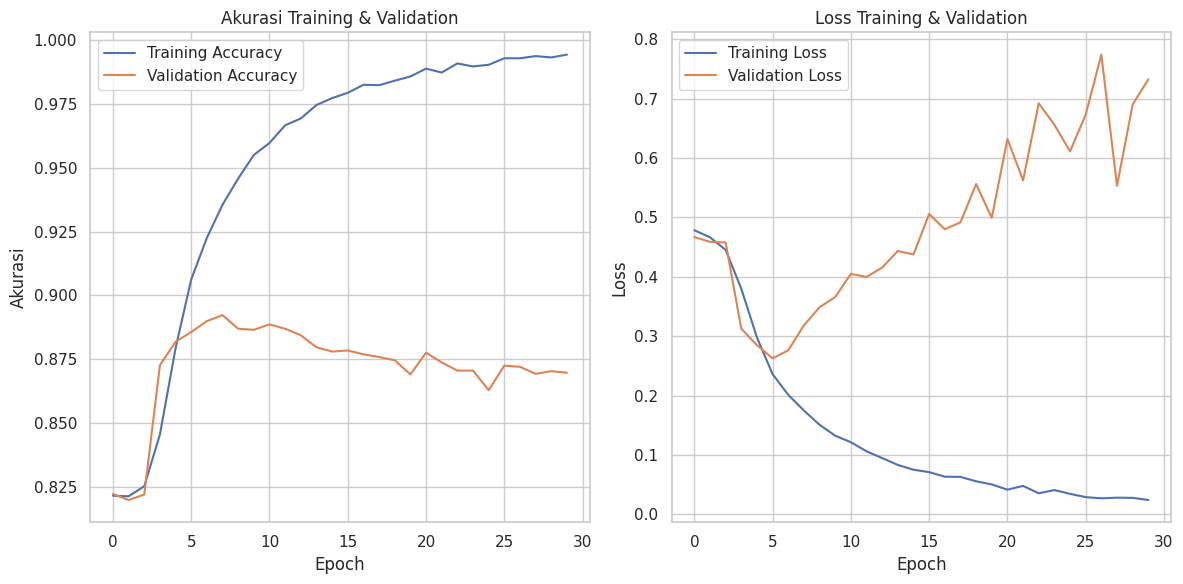

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Training & Validation')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Training & Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


---

## 🔐 Persamaan Matematika LSTM

### 1. **Forget Gate** – Apa yang harus dilupakan?
$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$
- Nilai $ f_t $ berada antara 0 (lupakan semua) dan 1 (ingat semua).
- Ini menentukan seberapa banyak informasi dari $ C_{t-1} $ yang akan diteruskan.

---

### 2. **Input Gate** – Apa yang harus disimpan?
$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
$$
$$
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$
- $ i_t $ adalah "gate" untuk kontrol penyimpanan info baru.
- $ \tilde{C}_t $ adalah kandidat nilai baru untuk cell state.

---

### 3. **Update Cell State**
$$
C_t = f_t * C_{t-1} + i_t * \tilde{C}_t
$$
- Cell state lama dikalikan dengan $ f_t $ untuk melupakan sebagian informasi.
- Lalu ditambahkan dengan input baru yang dikontrol oleh $ i_t $.

---

### 4. **Output Gate** – Apa yang akan dikeluarkan?
$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
$$
$$
h_t = o_t * \tanh(C_t)
$$
- Output state $ h_t $ adalah hasil akhir dari LSTM pada waktu $ t $.
- Ini juga yang dikirim ke time-step berikutnya.

---

## 📌 Ringkasan Aliran Informasi LSTM

```
x_t + h_{t-1}
     ↓
[Forget gate] → seberapa banyak informasi lama dibuang
[Input gate]  → seberapa banyak info baru disimpan
[Output gate] → apa yang dikirim keluar
```

---

## 🛠 Kenapa LSTM lebih baik dari RNN biasa?

- **RNN biasa** rentan terhadap *vanishing gradient* → gagal belajar ketergantungan jangka panjang.
- **LSTM** menyimpan "state memori" dengan lebih baik karena gate-gate tadi → lebih jago untuk urutan panjang (misal: teks review).

---

### Proses Training Model GRU

In [123]:
import numpy as np

X_latih = np.load('X_latih_seq.npy')
X_uji = np.load('X_uji_seq.npy')
y_latih = np.load('y_latih.npy')
y_uji = np.load('y_uji.npy')


In [124]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

# Ukuran input
panjang_input = X_latih.shape[1]
ukuran_vocab = len(kamus_kata)
dimensi_embedding = 128

model_gru = Sequential([
    Embedding(input_dim=ukuran_vocab, output_dim=dimensi_embedding, input_length=panjang_input),
    GRU(units=64, return_sequences=False),
    Dense(1, activation='sigmoid')
])


In [125]:
model_gru.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')]
)

print("✅ Model GRU dikompilasi.")


✅ Model GRU dikompilasi.


In [126]:
history_gru = model_gru.fit(
    X_latih, y_latih,
    validation_data=(X_uji, y_uji),
    epochs=30,
    batch_size=32
)


Epoch 1/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 58s 94ms/step - auc: 0.4898 - binary_accuracy: 0.8198 - loss: 0.4827 - val_auc: 0.5269 - val_binary_accuracy: 0.8223 - val_loss: 0.4672
Epoch 2/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 56s 95ms/step - auc: 0.6703 - binary_accuracy: 0.8381 - loss: 0.4113 - val_auc: 0.9304 - val_binary_accuracy: 0.8957 - val_loss: 0.2459
Epoch 3/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 81s 94ms/step - auc: 0.9458 - binary_accuracy: 0.9084 - loss: 0.2179 - val_auc: 0.9319 - val_binary_accuracy: 0.8940 - val_loss: 0.2559
Epoch 4/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - auc: 0.9698 - binary_accuracy: 0.9363 - loss: 0.1621 - val_auc: 0.9132 - val_binary_accuracy: 0.8927 - val_loss: 0.3041
Epoch 5/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - auc: 0.9830 - binary_accuracy: 0.9582 - loss: 0.1172 - val_auc: 0.8912 - val_binary_accuracy: 0.8889 - val_loss: 0.3600
Epoch 6/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 54s 93ms/step - auc: 0.9899 - binary_accuracy: 0.9719 - loss: 0.0844 - val_auc: 

In [127]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Prediksi
y_pred_prob = model_gru.predict(X_uji)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluasi
print(f"📊 Akurasi: {accuracy_score(y_uji, y_pred):.4f}")
print(f"📊 Presisi: {precision_score(y_uji, y_pred):.4f}")
print(f"📊 Recall: {recall_score(y_uji, y_pred):.4f}")
print(f"📊 F1 Score: {f1_score(y_uji, y_pred):.4f}")
print(f"📊 AUC: {roc_auc_score(y_uji, y_pred_prob):.4f}")


147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
📊 Akurasi: 0.8797
📊 Presisi: 0.9120
📊 Recall: 0.9449
📊 F1 Score: 0.9282
📊 AUC: 0.8841


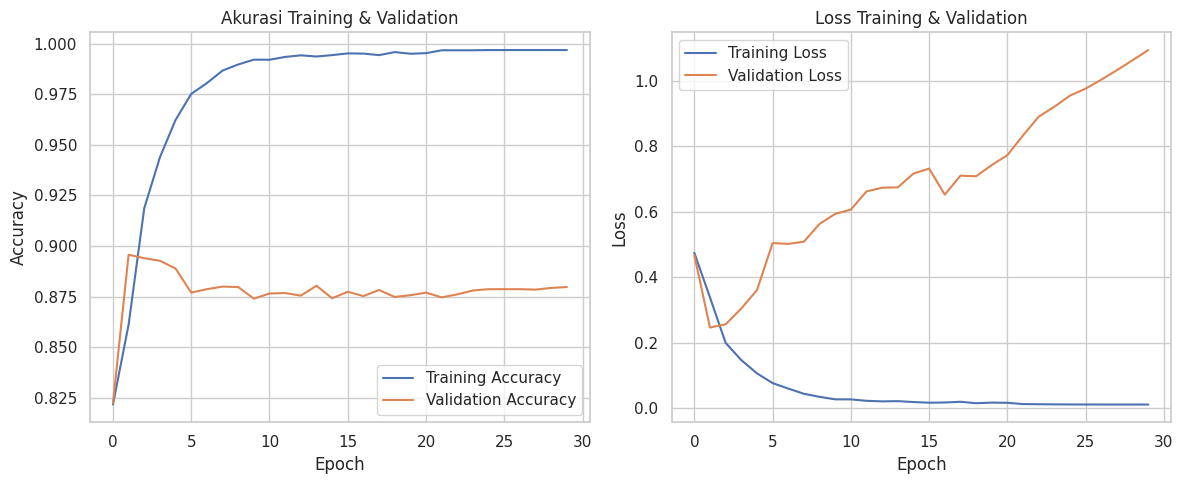

In [128]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history_gru.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Training & Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Loss Training & Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


---

## 🔁 GRU: Gated Recurrent Unit

GRU adalah jenis **Recurrent Neural Network (RNN)** yang lebih efisien dari LSTM karena memiliki struktur lebih simpel tapi tetap powerful dalam mengingat konteks waktu.

### Di dalam setiap sel GRU, ada:
- **Reset Gate (`r_t`)**
- **Update Gate (`z_t`)**
- **Candidate Activation (`\tilde{h}_t`)**
- **Final Hidden State (`h_t`)**

---

## 💡 Notasi Dasar

- `x_t` = input pada waktu ke-`t`  
- `h_{t-1}` = hidden state dari waktu sebelumnya  
- `W`, `U`, `b` = bobot dan bias untuk masing-masing gate  
- `σ()` = sigmoid activation function  
- `tanh()` = hyperbolic tangent activation function

---

## ✍️ Persamaan-Persamaan GRU

---

### 1. **Update Gate `z_t`**

> Mengontrol seberapa banyak informasi dari *masa lalu* yang dibawa ke waktu sekarang.

$$
z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)
$$

- `σ()` menjaga hasil dalam rentang [0, 1]
- Jika `z_t` mendekati 1 → `h_t` lebih mirip dengan `h_{t-1}`
- Jika `z_t` mendekati 0 → lebih fokus pada `\tilde{h}_t` (state baru)

---

### 2. **Reset Gate `r_t`**

> Mengontrol seberapa banyak informasi *masa lalu* yang akan "dilupakan".

$$
r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)
$$

- Jika `r_t` = 0 → mengabaikan `h_{t-1}`
- Jika `r_t` = 1 → gunakan sepenuhnya `h_{t-1}`

---

### 3. **Candidate Activation `\tilde{h}_t`**

> Ini adalah kandidat state baru (hasil update dari kombinasi `x_t` dan `h_{t-1}`)

$$
\tilde{h}_t = \tanh(W_h x_t + U_h (r_t \circ h_{t-1}) + b_h)
$$

- `\circ` artinya perkalian elemen-per-elemen (Hadamard product)
- Kalau `r_t` kecil → `h_{t-1}` sedikit berkontribusi → artinya lebih "melupakan"

---

### 4. **Final Hidden State `h_t`**

> Kombinasi antara `h_{t-1}` dan kandidat `\tilde{h}_t` sesuai kontrol dari `z_t`.

$$
h_t = (1 - z_t) \circ \tilde{h}_t + z_t \circ h_{t-1}
$$

- Kalau `z_t` besar → banyak ambil dari `h_{t-1}`
- Kalau `z_t` kecil → banyak ambil dari kandidat `\tilde{h}_t`

---

## 🧠 Intuisi

- GRU **bisa memilih kapan harus mengingat**, kapan harus melupakan.
- Tidak ada *output gate* seperti LSTM, sehingga lebih ringan dan cepat dilatih.

---

### PyTorch

### Persiapan Awal PyTorch

In [129]:
import numpy as np

X_train = np.load('X_latih_seq.npy')
X_test = np.load('X_uji_seq.npy')
y_train = np.load('y_latih.npy')
y_test = np.load('y_uji.npy')


In [130]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [131]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


### RNN Models Dengan PyTorch

In [132]:
import numpy as np

# Load data
X_latih = np.load('X_latih_seq.npy')
X_uji = np.load('X_uji_seq.npy')
y_latih = np.load('y_latih.npy')
y_uji = np.load('y_uji.npy')


In [133]:
import torch
from torch.utils.data import Dataset, DataLoader

# Dataset custom
class ReviewDataset(Dataset):
    def __init__(self, data, label):
        self.data = torch.tensor(data, dtype=torch.long)  # ubah ke tensor integer
        self.label = torch.tensor(label, dtype=torch.float32)  # ubah ke tensor float

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

# Buat dataset
train_dataset = ReviewDataset(X_latih, y_latih)
test_dataset = ReviewDataset(X_uji, y_uji)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


### Bangun Model RNN PyTorch

In [134]:
import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        output, hidden = self.rnn(x)
        out = self.fc(hidden.squeeze(0))
        return self.sigmoid(out)


### Inisialisasi Model, Loss, Optimizer

In [135]:
# Param dasar
vocab_size = len(kamus_kata)
embedding_dim = 128
hidden_dim = 128

# Model, loss, optimizer
model_rnn = RNNClassifier(vocab_size, embedding_dim, hidden_dim)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)


### Training Loop

In [146]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs=30):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch).squeeze()
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = (torch.sigmoid(output) >= 0.5).long()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                val_output = model(X_val).squeeze()
                v_loss = loss_fn(val_output, y_val)
                val_loss += v_loss.item()
                val_preds = (torch.sigmoid(val_output) >= 0.5).long()
                val_correct += (val_preds == y_val).sum().item()
                val_total += y_val.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        print(f"📚 Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [148]:
from torch.utils.data import TensorDataset, DataLoader
y_uji_tensor = torch.tensor(y_uji, dtype=torch.float32).to(device)
val_dataset = TensorDataset(X_uji_tensor, y_uji_tensor)
val_loader = DataLoader(val_dataset, batch_size=32)


In [149]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model_rnn, train_loader, val_loader, loss_fn, optimizer, epochs=30
)


📚 Epoch 1/30 | Train Loss: 0.3669, Train Acc: 0.8224 | Val Loss: 0.7039, Val Acc: 0.8223
📚 Epoch 2/30 | Train Loss: 0.3643, Train Acc: 0.8224 | Val Loss: 0.6650, Val Acc: 0.8223
📚 Epoch 3/30 | Train Loss: 0.3644, Train Acc: 0.8224 | Val Loss: 0.6842, Val Acc: 0.8223
📚 Epoch 4/30 | Train Loss: 0.3721, Train Acc: 0.8224 | Val Loss: 0.7207, Val Acc: 0.8223
📚 Epoch 5/30 | Train Loss: 0.3670, Train Acc: 0.8224 | Val Loss: 0.6931, Val Acc: 0.8223
📚 Epoch 6/30 | Train Loss: 0.3618, Train Acc: 0.8224 | Val Loss: 0.7075, Val Acc: 0.8223
📚 Epoch 7/30 | Train Loss: 0.3607, Train Acc: 0.8224 | Val Loss: 0.6854, Val Acc: 0.8223
📚 Epoch 8/30 | Train Loss: 0.3600, Train Acc: 0.8224 | Val Loss: 0.6920, Val Acc: 0.8223
📚 Epoch 9/30 | Train Loss: 0.3591, Train Acc: 0.8224 | Val Loss: 0.7298, Val Acc: 0.8223
📚 Epoch 10/30 | Train Loss: 0.3638, Train Acc: 0.8224 | Val Loss: 0.7611, Val Acc: 0.8223
📚 Epoch 11/30 | Train Loss: 0.3638, Train Acc: 0.8224 | Val Loss: 0.7089, Val Acc: 0.8223
📚 Epoch 12/30 | Tra

### Evaluasi Model

In [150]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Konversi X_uji ke tensor
X_uji_tensor = torch.tensor(X_uji_seq, dtype=torch.long).to(device)

# Prediksi
model_rnn.eval()
with torch.no_grad():
    output = model_rnn(X_uji_tensor).squeeze()
    pred_probs = torch.sigmoid(output).cpu().numpy()
    y_pred = (pred_probs >= 0.5).astype(int)

# Konversi y_uji ke NumPy (pastikan ini NumPy array, bukan tensor)
y_true = y_uji if isinstance(y_uji, np.ndarray) else y_uji.values

# Evaluasi
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, pred_probs)

# Output hasil
print(f"📊 Akurasi: {acc:.4f}")
print(f"📊 Presisi: {prec:.4f}")
print(f"📊 Recall: {rec:.4f}")
print(f"📊 F1 Score: {f1:.4f}")
print(f"📊 AUC: {auc:.4f}")


📊 Akurasi: 0.8223
📊 Presisi: 0.8223
📊 Recall: 1.0000
📊 F1 Score: 0.9025
📊 AUC: 0.4943


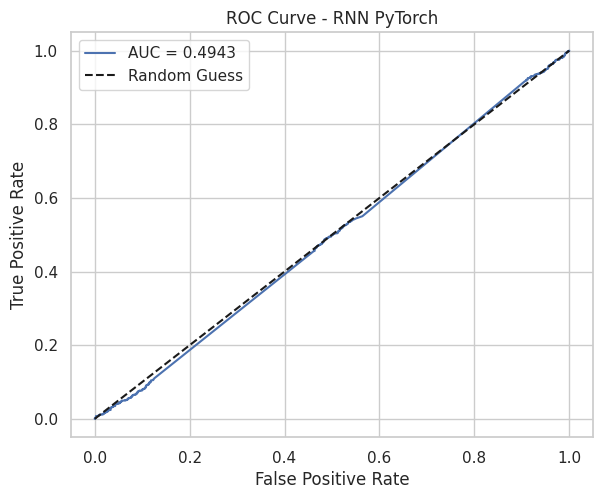

In [151]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, pred_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RNN PyTorch')
plt.legend()
plt.grid(True)
plt.show()

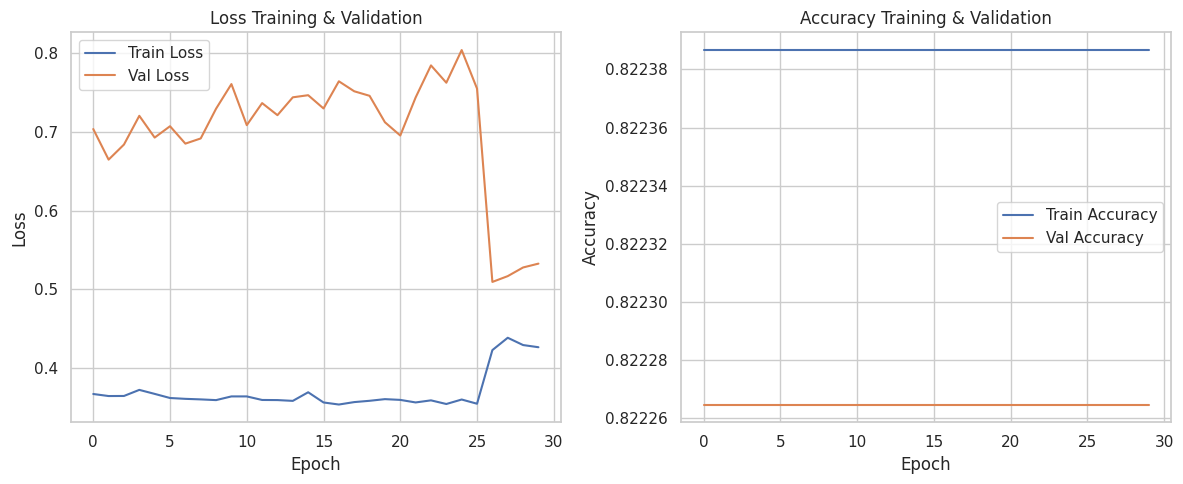

In [152]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Training & Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy Training & Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


---

### 📘 1. **Input ke Hidden State**
Untuk setiap time step $ t $, RNN menerima input $ x_t $ dan hidden state dari step sebelumnya $ h_{t-1} $, lalu menghitung hidden state sekarang $ h_t $:

$$
h_t = \tanh(W_{xh}x_t + W_{hh}h_{t-1} + b_h)
$$

**Penjelasan**:
- $ x_t $: input di urutan ke-$ t $ (biasanya vektor embedding dari satu kata).
- $ h_{t-1} $: hidden state sebelumnya (memory dari urutan sebelumnya).
- $ W_{xh} $: bobot dari input ke hidden.
- $ W_{hh} $: bobot dari hidden sebelumnya ke hidden sekarang.
- $ b_h $: bias.
- $ \tanh $: fungsi aktivasi, bikin output tetap dalam range $-1$ sampai $1$ dan menambahkan non-linearitas.

---

### 📘 2. **Hidden State ke Output**
Setelah selesai memproses semua urutan, hidden state terakhir bisa digunakan untuk prediksi output (dalam kasus ini: klasifikasi biner).

$$
\hat{y} = \sigma(W_{hy}h_T + b_y)
$$

**Penjelasan**:
- $ h_T $: hidden state terakhir (setelah semua kata diproses).
- $ W_{hy} $: bobot dari hidden state ke output.
- $ b_y $: bias output.
- $ \sigma $: sigmoid function karena klasifikasinya biner, hasil antara 0 dan 1.

---

### 📘 3. **Loss Function**
Model pakai **Binary Cross Entropy Loss**, ini rumus umumnya:

$$
\mathcal{L} = - \left( y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right)
$$

**Penjelasan**:
- $ y $: label asli (0 atau 1).
- $ \hat{y} $: probabilitas prediksi model.
- Loss ini bikin prediksi makin "deket" ke label asli.

---

### 📘 4. **Backpropagation**
Di belakang layar, PyTorch menghitung turunan dari loss terhadap parameter model (misalnya $ W_{xh}, W_{hh}, W_{hy} $) dengan **backpropagation through time (BPTT)**.

---

### 🧠 Intuisi Singkat
- Di setiap step, RNN gabungin info baru (kata ke-$t$) dengan memory sebelumnya (hidden state).
- Setelah semua kata diproses, RNN punya *representasi* kalimat dalam bentuk $ h_T $, yang bisa dipakai untuk klasifikasi.
- Karena dia “recurrent”, memory bisa mengalir ke depan, cocok banget buat data sekuensial seperti review.

---

### Model LSTM Dengan PyTorch

In [153]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim=1):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        final_hidden_state = lstm_out[:, -1, :]  # Ambil hidden state terakhir
        output = self.fc(final_hidden_state)
        return output


In [154]:
# Parameter
vocab_size = len(kamus_kata)
embed_dim = 100
hidden_dim = 128

# Inisialisasi model
model_lstm = LSTMClassifier(vocab_size, embed_dim, hidden_dim).to(device)

# Loss dan optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)


In [155]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs=30):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch).squeeze()
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.sigmoid(output) >= 0.5
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validasi
        model.eval()
        with torch.no_grad():
            val_loss, val_correct, val_total = 0, 0, 0
            for X_val, y_val in val_loader:
                val_output = model(X_val).squeeze()
                loss = loss_fn(val_output, y_val)
                val_loss += loss.item()

                val_preds = torch.sigmoid(val_output) >= 0.5
                val_correct += (val_preds == y_val).sum().item()
                val_total += y_val.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"📚 Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs


In [156]:
train_losses, val_losses, train_accs, val_accs = train_model(
    model_lstm, train_loader, val_loader, loss_fn, optimizer, epochs=30
)


📚 Epoch 1/30, Train Loss: 0.4718, Val Loss: 0.4661, Val Acc: 0.8225
📚 Epoch 2/30, Train Loss: 0.4665, Val Loss: 0.4678, Val Acc: 0.8223
📚 Epoch 3/30, Train Loss: 0.4120, Val Loss: 0.3499, Val Acc: 0.8267
📚 Epoch 4/30, Train Loss: 0.2982, Val Loss: 0.2961, Val Acc: 0.8734
📚 Epoch 5/30, Train Loss: 0.2402, Val Loss: 0.2721, Val Acc: 0.8859
📚 Epoch 6/30, Train Loss: 0.2008, Val Loss: 0.2663, Val Acc: 0.8929
📚 Epoch 7/30, Train Loss: 0.1693, Val Loss: 0.2684, Val Acc: 0.8912
📚 Epoch 8/30, Train Loss: 0.1372, Val Loss: 0.3254, Val Acc: 0.8868
📚 Epoch 9/30, Train Loss: 0.1111, Val Loss: 0.3696, Val Acc: 0.8872
📚 Epoch 10/30, Train Loss: 0.0908, Val Loss: 0.3853, Val Acc: 0.8891
📚 Epoch 11/30, Train Loss: 0.0760, Val Loss: 0.3879, Val Acc: 0.8846
📚 Epoch 12/30, Train Loss: 0.0644, Val Loss: 0.4094, Val Acc: 0.8880
📚 Epoch 13/30, Train Loss: 0.0552, Val Loss: 0.4260, Val Acc: 0.8859
📚 Epoch 14/30, Train Loss: 0.0475, Val Loss: 0.4231, Val Acc: 0.8836
📚 Epoch 15/30, Train Loss: 0.0399, Val Loss

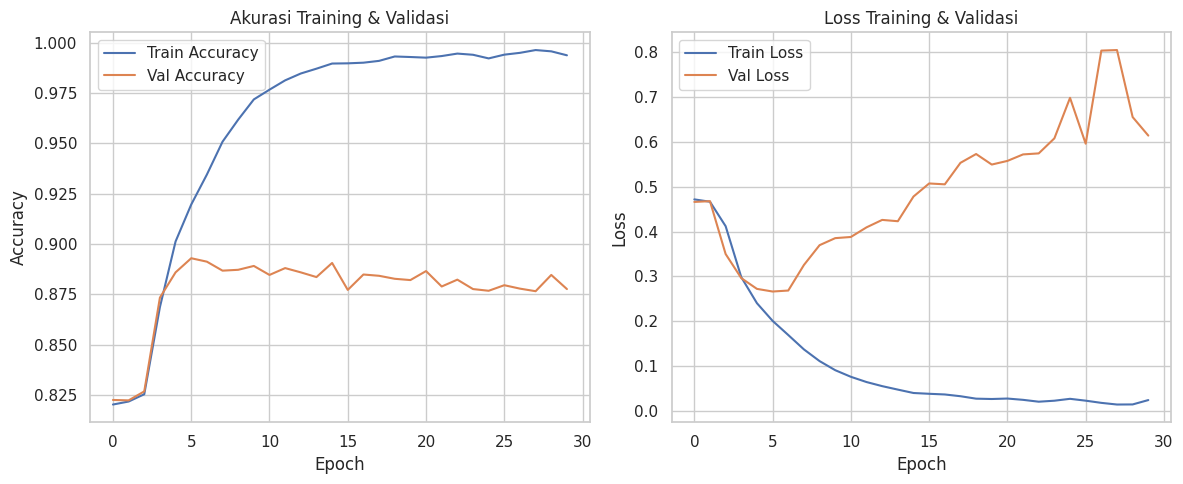

In [157]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Akurasi Training & Validasi')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Training & Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [158]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Pastikan data uji sudah jadi tensor
X_uji_tensor = torch.tensor(X_uji_seq, dtype=torch.long).to(device)
y_uji_tensor = torch.tensor(y_uji, dtype=torch.float).to(device)

# Prediksi
model_lstm.eval()
with torch.no_grad():
    output = model_lstm(X_uji_tensor).squeeze()
    pred_probs = torch.sigmoid(output).cpu().numpy()
    y_pred = (pred_probs >= 0.5).astype(int)

# Konversi y_true
y_true = y_uji_tensor.cpu().numpy()

# Hitung metrik
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, pred_probs)

# Tampilkan
print(f"📊 Akurasi: {acc:.4f}")
print(f"📊 Presisi: {prec:.4f}")
print(f"📊 Recall: {rec:.4f}")
print(f"📊 F1 Score: {f1:.4f}")
print(f"📊 AUC: {auc:.4f}")


📊 Akurasi: 0.8776
📊 Presisi: 0.9279
📊 Recall: 0.9229
📊 F1 Score: 0.9254
📊 AUC: 0.8910


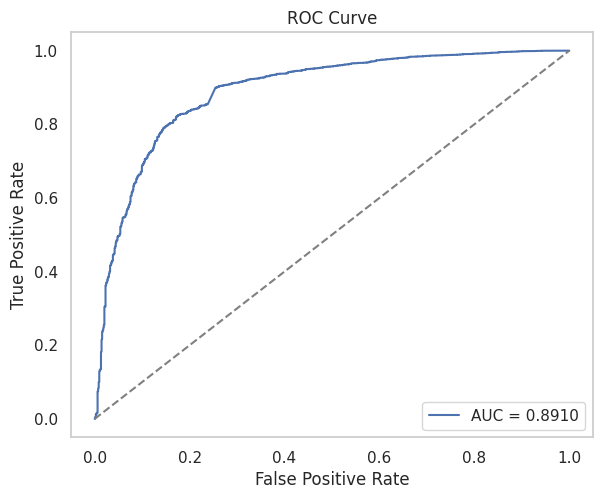

In [159]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, pred_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


---

## 🔁 Struktur Dasar LSTM

LSTM punya **3 gerbang utama** yang mengatur aliran informasi:
1. **Forget Gate** 🧽
2. **Input Gate** ✍️
3. **Output Gate** 📤

Dan juga **cell state** `C_t` yang menyimpan memori jangka panjang.

---

### 🧠 Notasi:
- `x_t` = input saat waktu `t`
- `h_t` = hidden state saat waktu `t`
- `C_t` = cell state saat waktu `t`
- `W` dan `b` = bobot dan bias yang dilatih
- `σ` = sigmoid function
- `tanh` = hyperbolic tangent function
- `*` = elemen-wise multiplication

---

## 📘 Persamaan Matematika LSTM

---

### 1. **Forget Gate**  
Menentukan berapa banyak informasi lama yang perlu dilupakan dari `C_{t-1}`.

$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$

- Fungsi sigmoid akan output antara 0–1
- Jika hasilnya 0 → buang semua memori lama
- Jika hasilnya 1 → pertahankan semua

---

### 2. **Input Gate**  
Menentukan berapa banyak informasi baru yang akan ditambahkan ke cell state.

$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
$$
$$
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$

- `i_t` = seberapa penting informasi baru
- `\tilde{C}_t` = kandidat nilai baru yang akan ditambahkan ke cell state

---

### 3. **Update Cell State**

$$
C_t = f_t * C_{t-1} + i_t * \tilde{C}_t
$$

- Ini kombinasi antara memori lama (`C_{t-1}`) dan informasi baru (`\tilde{C}_t`)
- Memungkinkan LSTM mempertahankan informasi jangka panjang

---

### 4. **Output Gate**

$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
$$
$$
h_t = o_t * \tanh(C_t)
$$

- `o_t` memutuskan bagian mana dari cell state yang akan dikeluarkan
- `h_t` ini yang dikirim ke waktu berikutnya & output akhir

---

## 🧠 Di PyTorch

Kalau pakai `nn.LSTM`, semua ini sudah dibungkus secara internal:

```python
self.lstm = nn.LSTM(input_size=100, hidden_size=128, batch_first=True)
```

- **`input_size`** → ukuran vektor input tiap timestep
- **`hidden_size`** → dimensi dari `h_t` dan `C_t`
- PyTorch secara otomatis menyimpan dan update `C_t` dan `h_t` di dalam training loop

---

## 🔚 Output LSTM

```python
output, (h_n, c_n) = self.lstm(x)
```

- `output` → semua hidden state `h_t` untuk setiap timestep
- `h_n` → hidden state terakhir (biasanya ini yang dipakai untuk klasifikasi)
- `c_n` → cell state terakhir

---

### Model GRU dengan PyTorch

In [160]:
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.gru(embedded)
        out = self.fc(hidden[-1])
        return self.sigmoid(out)


In [163]:
import torch

# Konversi data latih dan label ke tensor
X_latih_tensor = torch.tensor(X_latih_seq, dtype=torch.long).to(device)
y_latih_tensor = torch.tensor(y_latih, dtype=torch.float32).to(device)


In [164]:
vocab_size = int(torch.max(X_latih_tensor)) + 1
embed_dim = 128
hidden_dim = 128

model_gru = GRUModel(vocab_size, embed_dim, hidden_dim).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr=0.001)


In [165]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs=30):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch).squeeze()
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = (output >= 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_accs.append(correct / total)

        # Validasi
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                val_output = model(X_val).squeeze()
                loss = loss_fn(val_output, y_val)
                val_loss += loss.item()

                val_preds = (val_output >= 0.5).float()
                val_correct += (val_preds == y_val).sum().item()
                val_total += y_val.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)

        print(f"📚 Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

    return train_losses, val_losses, train_accs, val_accs

# Training model
train_losses, val_losses, train_accs, val_accs = train_model(model_gru, train_loader, val_loader, loss_fn, optimizer, epochs=30)


📚 Epoch 1/30, Loss: 0.3761, Val Loss: 0.2750, Val Acc: 0.8789
📚 Epoch 2/30, Loss: 0.2340, Val Loss: 0.2419, Val Acc: 0.8972
📚 Epoch 3/30, Loss: 0.1800, Val Loss: 0.2517, Val Acc: 0.8997
📚 Epoch 4/30, Loss: 0.1341, Val Loss: 0.2764, Val Acc: 0.8968
📚 Epoch 5/30, Loss: 0.0909, Val Loss: 0.3202, Val Acc: 0.8902
📚 Epoch 6/30, Loss: 0.0631, Val Loss: 0.3873, Val Acc: 0.8885
📚 Epoch 7/30, Loss: 0.0433, Val Loss: 0.4245, Val Acc: 0.8906
📚 Epoch 8/30, Loss: 0.0308, Val Loss: 0.5027, Val Acc: 0.8870
📚 Epoch 9/30, Loss: 0.0277, Val Loss: 0.4961, Val Acc: 0.8893
📚 Epoch 10/30, Loss: 0.0282, Val Loss: 0.5538, Val Acc: 0.8846
📚 Epoch 11/30, Loss: 0.0201, Val Loss: 0.5587, Val Acc: 0.8919
📚 Epoch 12/30, Loss: 0.0203, Val Loss: 0.5935, Val Acc: 0.8912
📚 Epoch 13/30, Loss: 0.0157, Val Loss: 0.6275, Val Acc: 0.8934
📚 Epoch 14/30, Loss: 0.0182, Val Loss: 0.5770, Val Acc: 0.8857
📚 Epoch 15/30, Loss: 0.0181, Val Loss: 0.6099, Val Acc: 0.8910
📚 Epoch 16/30, Loss: 0.0254, Val Loss: 0.5763, Val Acc: 0.8931
📚

📊 Akurasi: 0.8223
📊 Presisi: 0.8223
📊 Recall: 1.0000
📊 F1 Score: 0.9025
📊 AUC: 0.9047


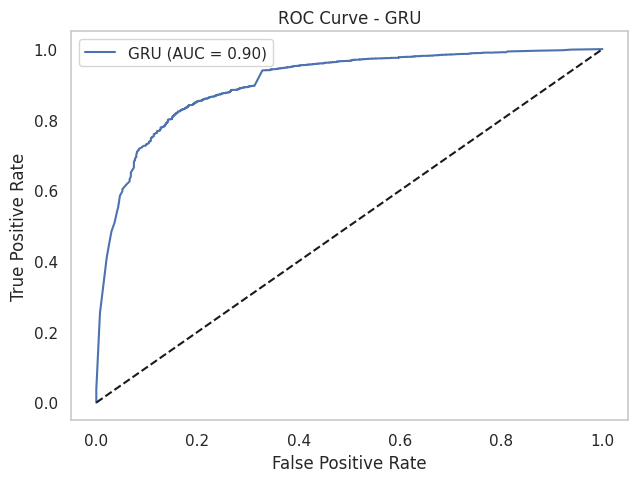

In [166]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

model_gru.eval()
with torch.no_grad():
    output = model_gru(X_uji_tensor).squeeze()
    pred_probs = torch.sigmoid(output).cpu().numpy()
    y_pred = (pred_probs >= 0.5).astype(int)

# Konversi label ke numpy
y_true = y_uji_tensor.cpu().numpy()

# Evaluasi
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, pred_probs)

print(f"📊 Akurasi: {acc:.4f}")
print(f"📊 Presisi: {prec:.4f}")
print(f"📊 Recall: {rec:.4f}")
print(f"📊 F1 Score: {f1:.4f}")
print(f"📊 AUC: {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, pred_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'GRU (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GRU')
plt.legend()
plt.grid()
plt.show()


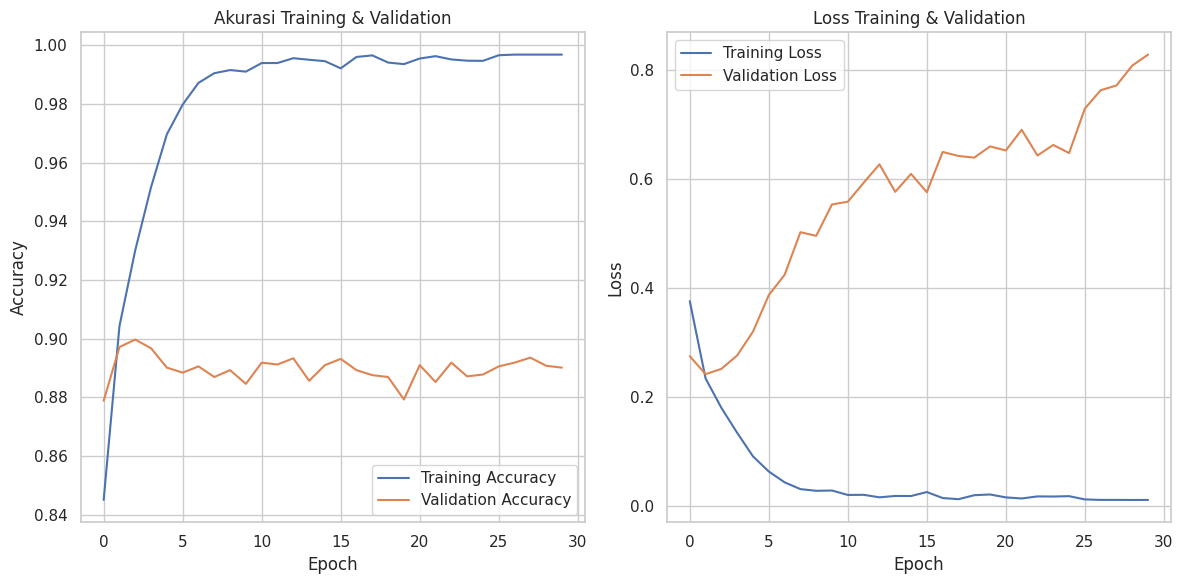

In [167]:
plt.figure(figsize=(12, 6))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Akurasi Training & Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Training & Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


---

## 🔍 Arsitektur GRU

GRU adalah varian dari RNN yang menggabungkan dua **gate**:  
1. **Update Gate** `zₜ`  
2. **Reset Gate** `rₜ`

Tujuannya untuk mengatasi **vanishing gradient** dan membuat model **ingat informasi penting lebih lama**.

---

## 💡 Persamaan GRU

Misalkan:
- $ x_t $: input pada waktu ke-𝑡
- $ h_{t-1} $: hidden state sebelumnya
- $ h_t $: hidden state saat ini
- $ \sigma $: sigmoid activation
- $ \tanh $: hyperbolic tangent activation

---

### 1. **Update Gate** $ z_t $

$$
z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)
$$

🔎 *Fungsi:* Mengontrol seberapa banyak informasi dari waktu sebelumnya ($ h_{t-1} $) yang akan dibawa ke waktu sekarang ($ h_t $).

---

### 2. **Reset Gate** $ r_t $

$$
r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)
$$

🔎 *Fungsi:* Mengontrol seberapa banyak dari masa lalu yang akan dilupakan. Jika gate ini kecil → informasi lama di-*reset*.

---

### 3. **Candidate Activation** $ \tilde{h}_t $

$$
\tilde{h}_t = \tanh(W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)
$$

🔎 *Fungsi:* Calon nilai hidden state baru. Dikalikan dulu dengan reset gate, agar hanya sebagian dari $ h_{t-1} $ yang dilanjutkan.

---

### 4. **Final Hidden State** $ h_t $

$$
h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
$$

🔎 *Fungsi:* Kombinasi antara hidden state lama dan yang baru. Update gate $ z_t $ yang mengontrol pencampuran ini.

---

## 🧠 Intuisi Sederhana

- **Update gate**: “Apa yang harus saya simpan dari masa lalu?”
- **Reset gate**: “Apa yang harus saya lupakan dari masa lalu?”
- **Hidden state**: “Informasi baru yang disesuaikan dengan yang penting dari masa lalu.”

---

## 💻 Implementasi di PyTorch

Saat pakai `nn.GRU(...)`, semua persamaan di atas sudah dibungkus dan dioptimalkan di dalam PyTorch. Secara internal, ia melakukan hal seperti:

```python
self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
```

Itu otomatis menangani:
- perhitungan `z_t`, `r_t`, dan `h_t`
- unrolling waktu
- tracking gradien untuk backpropagation

---